In [640]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import scipy as sp
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-dark")
sns.set_palette("bright")
b, o, g, r, p, brown, pink, grey, y, lb = np.array(sns.color_palette())

mpl.rc('axes', labelsize=14, titlesize=16)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [641]:
import pandas as pd
data = pd.read_csv("/home/claym0re/Projects/python3/machine-learning/ml-algorithms/datasets/house-prices/train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [642]:
X_raw = data[["SalePrice", "OverallQual"]]
y_raw = data["YearBuilt"]

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

column_transformer = ColumnTransformer([
    ("imputer", SimpleImputer(), ["LotFrontage"]),
    ("minmax1", MinMaxScaler((0,10)), ["SalePrice"]),
    ("minmax2", MinMaxScaler((0,10)), ["LotFrontage"])],remainder="passthrough")

In [644]:
# from sklearn.pipeline import make_pipeline
# from sklearn.pipeline import Pipeline

# transformation_pipeline = make_pipeline(column_transformer, StandardScaler(), SimpleImputer())
# X = np.delete(transformation_pipeline.fit_transform(X_raw), 0, 1)
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X_raw)

In [645]:
y = np.where(y_raw>=1980, 1, 0).reshape(-1,)
np.unique(y, return_counts=True)

(array([0, 1]), array([848, 612]))

In [800]:
class SVMc:
    '''Support Vector Machine Classification with Stochastic Gradient Descent'''
    def __init__(self, learning_rate=0.1, max_iter=1000, lbd=0.1, tol=1e-12):
        self.alpha = learning_rate
        self.max_iter = max_iter
        self.lbd = lbd
        self.tol = tol


    def fit(self, X, y):
        
        n_samples, n_features = X.shape
        
        self.X = X
        self.y = np.where(y==0, -1, 1)
        
        # init parameters
        self.weights = np.zeros(n_features)
        self.ww = []
        self.bias = 0
        self.losses = []
        self.scores = []

        # gradient descent
        for itr in range(self.max_iter):
            loss = 0
            theta = 0
            for xi, yi in zip(self.X, self.y):
                y_pred = self.decision_function(xi)                          
                # computing the gradient given the condition
                condition = (yi * y_pred >= 1)
                
                if condition:                     ##if classified correctly
                    dW = self.lbd * self.weights
                    dB = 0
                else:
                    loss += 1
                    dW = (self.lbd * self.weights) - np.dot(xi, yi)
                    dB = self.decision_function(xi)
                
                # updating the parameters
                self.weights -= self.alpha * dW
                self.bias -= self.alpha * dB
            
            theta += self.weights.flatten()
            self.ww.append(theta)
            self.losses.append(loss)
            
        print(self.weights, self.bias)
    def decision_function(self, X):
        return np.dot(X, self.weights.T) + self.bias
    
    def predict(self, X):                    
        return np.sign(self.decision_function(X))
    
    def score(self, X, y):
        y_ = list(np.where(y==0,-1,1))
        return np.sum(y_ == self.predict(X))/len(y_)
                                            
    def transform(self, X, y):
        pass

In [801]:
svc = SVMc(learning_rate=1e-4, max_iter=1000, lbd=1e-10)
svc.fit(X[:1000], y[:1000])

[0.77771682 1.34903763] -0.1952029335338057


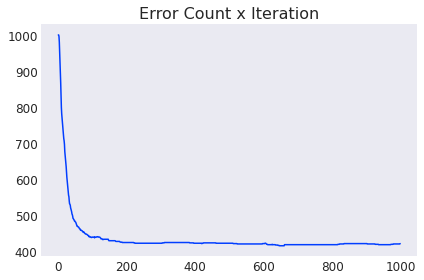

In [802]:
plt.title("Error Count x Iteration")
plt.plot(np.arange(0,len(svc.losses)), svc.losses, "-")
plt.tight_layout()

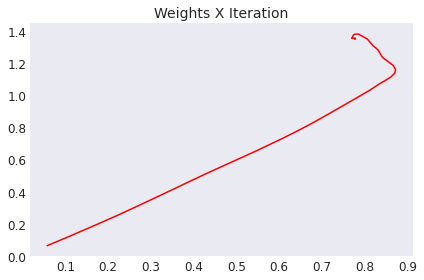

In [803]:
plt.title("Weights X Iteration", fontsize=14)
plt.plot(np.array(svc.ww)[:,0], np.array(svc.ww)[:,1], "r")
plt.tight_layout()

In [804]:
print("Test Score: ", svc.score(X[1000:], y[1000:]))

Test Score:  0.8282608695652174


In [805]:
print("Test Predictions Count: ",np.unique(svc.predict(X[1000:]), return_counts=True))
print("Test Labels Count: ", np.unique(np.where(y[1000:]==0, -1,1), return_counts=True))

Test Predictions Count:  (array([-1.,  1.]), array([283, 177]))
Test Labels Count:  (array([-1,  1]), array([274, 186]))


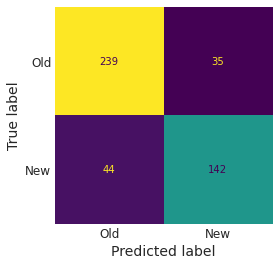

In [806]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y[1000:], np.where(svc.predict(X[1000:]) == -1,0,1)), display_labels=["Old", "New"]).plot(colorbar=False)

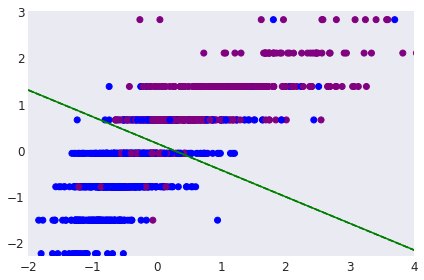

In [818]:
sv1 = np.min([x for x in svc.decision_function(X) if x>=1])
sv0 = np.max([x for x in svc.decision_function(X) if x<1])
# Plot data points and color using their class
color = ['blue' if c == 0 else 'purple' for c in y]
plt.scatter(X[:,0], X[:,1], c=color)

# Create the hyperplane
w = svc.weights
a = -w[0] / w[1]
xx = np.linspace(-2.5, 5)
yy = a * xx - (svc.bias) / w[1]
yy1 = (a * xx - (svc.bias) / w[1]) + sv1-1
yy0 = (a * xx - (svc.bias) / w[1]) - (1-sv0)


# Plot the hyperplane
plt.plot(xx, yy, "g")
plt.plot(xx, yy1, "g--")
plt.plot(xx, yy0, "g--")

plt.axis([-2, 4, -2.3, 3])
plt.tight_layout()

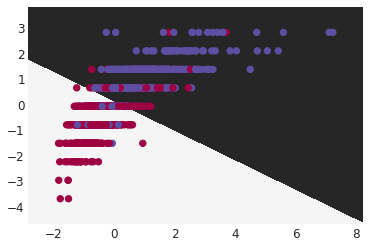

In [817]:
def plot_contour(X, y, svm):
    # plot the resulting classifier
    h = 0.001
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]

    Z = svm.predict(points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.9)

    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()

plot_contour(X,y,svc)

In [1]:
class SVM:
    def __init__(self, kernel='linear', C=10000.0, max_iter=100000, degree=3, gamma=1):
        self.kernel = {'poly':lambda x,y: np.dot(x, y.T)**degree,
                       'rbf':lambda x,y:np.exp(-gamma*np.sum((y-x[:,np.newaxis])**2,axis=-1)),
                       'linear':lambda x,y: np.dot(x, y.T)}[kernel]
        self.C = C
        self.max_iter = max_iter

    def restrict_to_square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  
    def fit(self, X, y):
        self.X = X.copy()
        self.y = y * 2 - 1
        self.lambdas = np.zeros_like(self.y, dtype=float)
        self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y

        for _ in range(self.max_iter):
            for idxM in range(len(self.lambdas)):
                idxL = np.random.randint(0, len(self.lambdas))
                Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
                v0 = self.lambdas[[idxM, idxL]]
                k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
                u = np.array([-self.y[idxL], self.y[idxM]])
                t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
                self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
    
        idx, = np.nonzero(self.lambdas > 1E-15)
        self.b = np.sum((1.0-np.sum(self.K[idx]*self.lambdas, axis=1))*self.y[idx])/len(idx)

    def decision_function(self, X):
        return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b